In [1]:
from dolfin import *
from rbnics import *
from rbnics.backends import export, transpose
from rbnics.backends.online import OnlineFunction, OnlineVector
from rbnics.utils.io import OnlineSizeDict
import numpy as np
from itertools import product

import h5py

from problems import *
from reduction_methods import *

from numpy import pi, random
from rbnics.sampling.distributions.distribution import Distribution

import matplotlib.pyplot as plt

In [2]:
# Set seed
seed = 10
np.random.seed(seed)

rate = 50

tol = 0 # 1e-6
N_max = 3 #19 # np.inf

In [3]:
!python mesh_gen.py

Mesh generated
Num vertices: 8801
Num elements: 17272
Max mesh element size: 0.01696751506338806
Min mesh element size: 0.008651377444941974


In [4]:
# Define the problem

@OnlineStabilization()
class AdvectionDominated(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        # Store advection and forcing expressions
        self.beta = Constant((1.0, 1.0))
        self.f = Constant(1.0)
        # Store terms related to stabilization
        self.delta = 0.5
        self.h = CellDiameter(V.mesh())

    # Return custom problem name
    def name(self):
        return "./data/rbnics"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 10.0**(- mu[0])
            theta_a1 = mu[1]
            if self.stabilized:
                delta = self.delta
                theta_a2 = - delta * 10.0**(- mu[0])
                theta_a3 = delta
            else:
                theta_a2 = 0.0
                theta_a3 = 0.0
            return (theta_a0, theta_a1, theta_a2, theta_a3)
        elif term == "f":
            theta_f0 = 1.0
            if self.stabilized:
                delta = self.delta
                theta_f1 = delta
            else:
                theta_f1 = 0.0
            return (theta_f0, theta_f1)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            beta = self.beta
            h = self.h
            a0 = inner(grad(u), grad(v)) * dx
            a1 = inner(beta, grad(u)) * v * dx
            a2 = inner(div(grad(u)), h * inner(beta, grad(v))) * dx
            a3 = inner(inner(beta, grad(u)), h * inner(beta, grad(v))) * dx
            return (a0, a1, a2, a3)
        elif term == "f":
            f = self.f
            beta = self.beta
            h = self.h
            f0 = f * v * dx
            f1 = inner(f, h * inner(beta, grad(v))) * dx
            return (f0, f1)
        elif term == "k":
            u = self.u
            k0 = inner(grad(u), grad(v)) * dx
            return (k0,)
        elif term == "m":
            u = self.u
            m0 = inner(u, v) * dx
            return (m0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [5]:
# 1. Read the mesh for this problem
mesh = Mesh(f"./data/mesh.xml")
subdomains = MeshFunction("size_t", mesh, f"./data/subdomains.xml")
boundaries = MeshFunction("size_t", mesh, f"./data/boundaries.xml")

In [6]:
# 2. Create Finite Element space (Lagrange P2)
V = FunctionSpace(mesh, "Lagrange", 2)

In [7]:
# 3. Allocate an object of the Stokes class
problem = AdvectionDominated(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.0, 6.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

In [8]:
# 4. Define parameter values to construct solution for
mus = [np.linspace(0., 6., 10), np.linspace(-1.0, 1.0, 10)]
mu1, mu2 = np.meshgrid(mus[0], mus[1])
samples = np.vstack((mu1.T, mu2.T)).reshape(2, -1).T

In [9]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(N_max)
reduction_method.set_tolerance(tol)

In [10]:
# Split parameter space for training and testing
num_graphs = samples.shape[0]
total_sims = int(num_graphs)
rate = rate/100
train_sims = int(rate * total_sims)
test_sims = total_sims - train_sims
main_loop = np.arange(total_sims).tolist()
np.random.shuffle(main_loop)

train_trajs = main_loop[0:train_sims]
train_trajs.sort()
test_trajs = main_loop[train_sims:total_sims]
test_trajs.sort()

In [11]:
# 5. Construct the solution

class DatasetSampler(Distribution):
    def __init__(self, training_samples):
        self.training_samples = list(map(tuple, training_samples))
        self.n = len(training_samples)

    def sample(self, _, n):
        assert n==self.n
        return self.training_samples

reduction_method.initialize_training_set(train_sims, sampling=DatasetSampler(samples[train_trajs]))
reduced_problem = reduction_method.offline()

=               ./data/rbnics POD-Galerkin offline phase begins                =

###################################### 0 #######################################
truth solve for mu = (0.0, -0.7777777777777778)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (0.0, -0.5555555555555556)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (0.0, -0.33333333333333337)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (0.0, -0.11111111111111116)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (0.0, 0.11111111111111116)
update snapshots matrix

###################################### 5 #######################################
truth solve for mu = (0.0, 0.33333333333333326)
update snapshots 


################################# perform POD ##################################
lambda_0 = 2402.4971060822036
lambda_1 = 1420.1607729341595
lambda_2 = 295.706193769407

build reduced operators

=                ./data/rbnics POD-Galerkin offline phase ends                 =



In [12]:
counter = 0

n_params = samples.shape[0]

projected_matrix = np.zeros((n_params, N_max))
reduced_matrix = np.zeros((n_params, mesh.num_vertices()))
snapshot_matrix = np.zeros((n_params, mesh.num_vertices()))
reduced_proj_matrix = np.zeros((n_params, mesh.num_vertices()))

dofmap = V.dofmap()
dofs = dofmap.dofs(mesh, 0)

for i, values in enumerate(samples):
    online_mu = tuple(values)

    # high-fidelity (truth solver)
    problem.set_mu(online_mu)
    snapshot = problem.solve()
    problem.export_solution(folder='data/highfid', filename="solution", suffix=counter)

    # Galerkin POD solver
    reduced_problem.set_mu(online_mu)
    reduced_solution = reduced_problem.solve()
    reduced_problem.export_solution(folder='data/galpod', filename="solution", suffix=counter)
    rb_nn = reduced_problem.basis_functions[["u"]] * reduced_solution.vector()
    reduced_matrix[i] = np.array(rb_nn.vector())[dofs]

    # Projection of HF solutions onto reduced space. Note: we only concern ourselves with u here
    projected_val = reduced_problem.project(snapshot).vector()
    projected_matrix[i] = np.array(projected_val)
    x_rb_rec = reduced_problem.basis_functions[["u"]] * projected_val
    reduced_proj_matrix[i] = np.array(x_rb_rec.vector())[dofs]

    counter+=1
    print(str(counter)+'/'+f'{samples.shape[0]}')

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


In [13]:
f = h5py.File("./data/highfid/solution.h5")

for i in range(n_params):
    snapshot_matrix[i] = np.array(f["VisualisationVector/"+str(i)])[:, 0]

In [14]:
snapshot_matrix[1], reduced_matrix[1], reduced_proj_matrix[1], projected_matrix[1]

(array([0.        , 0.        , 0.        , ..., 0.04414837, 0.04662662,
        0.04505316]),
 array([0.        , 0.        , 0.        , ..., 0.03573553, 0.03658847,
        0.03626569]),
 array([0.        , 0.        , 0.        , ..., 0.03687203, 0.03772501,
        0.03741461]),
 array([-0.13757921,  0.00945869, -0.07643372]))

In [1]:
# reduced_proj_matrix[i] == basis_matrix @ projected_coeff_matrix[i]
basis_matrix = np.array(list(map(lambda x: np.array(x.vector()), reduced_problem.basis_functions[["u"]])))[:, dofs].T.reshape(mesh.num_vertices(), N_max)

NameError: name 'np' is not defined

In [16]:
np.save('data/snapshot_matrix_large.npy', snapshot_matrix)
np.save('data/reduced_matrix.npy', reduced_matrix)
np.save('data/reduced_proj_matrix.npy', reduced_proj_matrix)
np.save('data/projected_matrix.npy', projected_matrix)
np.save('data/basis_matrix.npy', basis_matrix)

In [17]:
def print_results(Z, Z_approx):
    Z = Z.T
    Z_approx = Z_approx.T
    
    error_abs_list = list()
    norm_z_list = list()

    for snap in range(Z.shape[1]):
        error_abs = np.linalg.norm(abs(Z[:, snap] - Z_approx[:, snap]))
        norm_z = np.linalg.norm(Z[:, snap], 2)
        error_abs_list.append(error_abs)
        norm_z_list.append(norm_z)

    error = np.array(error_abs_list)
    norm = np.array(norm_z_list)
    rel_error = error/norm
    print("\nMaximum absolute error for field "+" = ", max(error))
    print("Mean absolute error for field "+" = ", sum(error)/len(error))
    print("Minimum absolute error for field "+" = ", min(error))
    print("\nMaximum relative error for field "+" = ", max(rel_error))
    print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
    print("Minimum relative error for field "+" = ", min(rel_error))

In [18]:
print_results(snapshot_matrix, reduced_matrix)


Maximum absolute error for field  =  38.311826429996735
Mean absolute error for field  =  13.519745900683048
Minimum absolute error for field  =  1.3355982944459863

Maximum relative error for field  =  0.708435504060052
Mean relative error for field  =  0.2665575054025919
Minimum relative error for field  =  0.07054424919564693


In [19]:
print_results(snapshot_matrix, reduced_proj_matrix)


Maximum absolute error for field  =  44.296172788019796
Mean absolute error for field  =  13.870192677902232
Minimum absolute error for field  =  1.3073877909688587

Maximum relative error for field  =  0.4739879096888139
Mean relative error for field  =  0.25189331642359514
Minimum relative error for field  =  0.07620184906283865


In [20]:
!python h5_to_mat.py

In [21]:
import xml.etree.ElementTree as ET
vertices = ET.parse("./data/mesh.xml").getroot()[0][0]

reference_mesh = np.zeros((mesh.num_vertices(), 2))

for vertex in vertices:
    reference_mesh[int(vertex.attrib['index']), 0] = np.double(vertex.attrib['x'])
    reference_mesh[int(vertex.attrib['index']), 1] = np.double(vertex.attrib['y'])

np.save('data/reference_mesh_large.npy', reference_mesh)

In [22]:
## From https://arxiv.org/pdf/2303.09080.pdf, "Node Subsampling for Multilevel Meshfree Elliptic PDE Solvers"

from sklearn.neighbors import NearestNeighbors
def MFNUS(xy, fc=1.5, K=10):
    """
    Moving Front Non-Uniform Subsampling
    Args:
    xy (array): initial node set to be subsample
    c (float): coarsening factor
    K (float): number of nerarest neighbors to check in algorithm
    Returns:
    xy_sub (array): subsampled node set
    """
    assert xy.shape[0] >= xy.shape[1]
    orig = xy
    # algorithm
    N = xy.shape[0] # Get the number of its dots
    sort_ind = np.lexsort(xy.T,axis=0)
    xy = xy[sort_ind, :] # Sort dots from bottom and up
    # Create nearest neighbor pointers and distances
    nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='auto').fit(xy)
    distances, indices = nbrs.kneighbors(xy)
    for k in range(N): # Loop over nodes from bottom and up
        if indices[k, 0] != N+1: # Check if node already eliminated
            ind = np.where(distances[k, 1:] < fc * distances[k, 1])[0]
            ind2 = indices[k, ind+1]
            ind2 = np.delete(ind2,ind2 < k) # Mark nodes above present one, and which
            indices[ind2, 0] = N+1 # are within the factor fc of the closest one
    elim_ind_sorted = indices[:, 0] != N+1
    xy_sub = xy[elim_ind_sorted]
    indexes = sort_ind[elim_ind_sorted]
    assert ((xy_sub-orig[indexes])**2).sum()==0
    return indexes

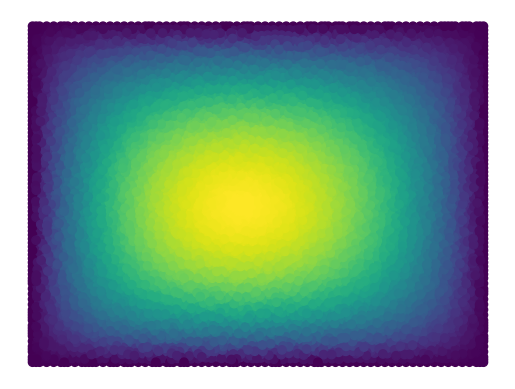

2746


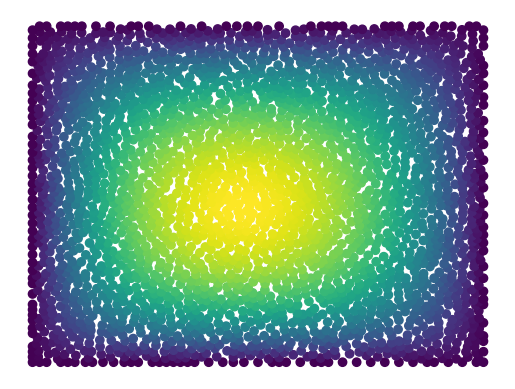

942


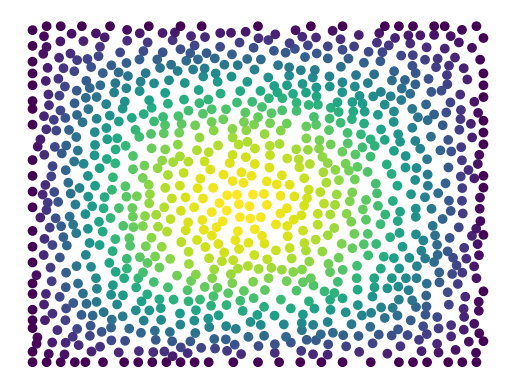

326


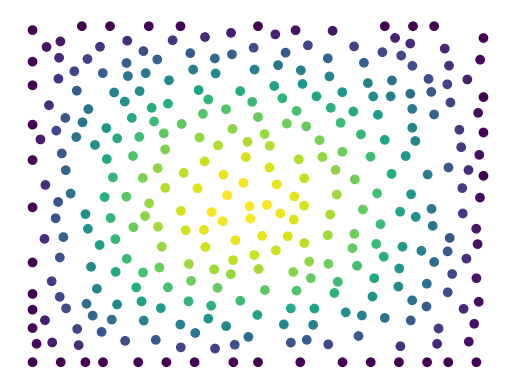

In [23]:
plt.scatter(reference_mesh[:, 0], reference_mesh[:, 1], c=snapshot_matrix[0, :])
plt.axis('off')
plt.show()




subsample = MFNUS(reference_mesh)
print(len(subsample))

subsampled_mesh = reference_mesh[subsample]
subsampled_solution = snapshot_matrix[:, subsample]

np.save('data/reference_mesh_medium.npy', subsampled_mesh)
np.save('data/snapshot_matrix_medium.npy', subsampled_solution)

plt.scatter(subsampled_mesh[:, 0], subsampled_mesh[:, 1], c=subsampled_solution[0, :])
plt.axis('off')
plt.show()




subsample = MFNUS(subsampled_mesh)
print(len(subsample))

subsampled_mesh = subsampled_mesh[subsample]
subsampled_solution = subsampled_solution[:, subsample]

np.save('data/reference_mesh_small.npy', subsampled_mesh)
np.save('data/snapshot_matrix_small.npy', subsampled_solution)

plt.scatter(subsampled_mesh[:, 0], subsampled_mesh[:, 1], c=subsampled_solution[0, :])
plt.axis('off')
plt.show()




subsample = MFNUS(subsampled_mesh)
print(len(subsample))

subsampled_mesh = subsampled_mesh[subsample]
subsampled_solution = subsampled_solution[:, subsample]

np.save('data/reference_mesh_tiny.npy', subsampled_mesh)
np.save('data/snapshot_matrix_tiny.npy', subsampled_solution)

plt.scatter(subsampled_mesh[:, 0], subsampled_mesh[:, 1], c=subsampled_solution[0, :])
plt.axis('off')
plt.show()